# Calculate radiance spectrum at the top of the atmosphere  

In [1]:
import numpy as np
import eradiate
#import matplotlib.pyplot as plt
from eradiate import unit_registry as ureg
from eradiate.scenes.atmosphere import MolecularAtmosphere
from eradiate import scenes as ertsc
#import xarray as xr

ImportError: Could not import module 'drjit'. If you are an end-user, you need to install the radiometric kernel by adding the 'kernel' extra to the installation command (e.g. pip install 'eradiate[kernel]'). If you are a developer, you have to build the kernel and add it to your $PYTHONPATH.

In [ ]:
eradiate.plot.set_style() 

### Define molecular absorption parameterization
 
We set the simulation mode to "ckd_double", which means that we use a correlated-k distribution and run the simuilation in double precision. 

We select the US standard atmosphere and choose the absorption parameterization "panellus" for hyperspectral simulations at a spectral resolution of 1nm.

In [ ]:

eradiate.set_mode("ckd_double")
atmosphere_gas=MolecularAtmosphere(
    thermoprops={
        "identifier": "afgl_1986-us_standard",
        "z": np.linspace(0.0, 120.0, 121) * ureg.km,
    },
    abs_param="panellus") 

### Define an aerosol layer

Here we define a uniform aerosol layer between 0 and 3 km altitude with an optical thickness of 2 at 550 nm. The aerosol optical properties correspond to the continental aerosol distribution as parameterized in the SIX6V RT model. 

In [ ]:
particle_layer = ertsc.atmosphere.ParticleLayer(tau_ref=2, w_ref=550, bottom=0, top=3*ureg.km, 
                                                distribution="uniform", dataset='sixsv-continental') 

Now we combine the molecular atmosphere and the aerosol layer.

In [ ]:
atmosphere = ertsc.atmosphere.HeterogeneousAtmosphere(
    molecular_atmosphere=atmosphere_gas, # MolecularAtmosphere(absorption_data="panellus"),
    particle_layers=[particle_layer]
)

### Define the surface albedo

We load a spectral surface albedo file extracted from HAMSTER data as an ascii file and define an InterpolatedSpectrum to be used in the simulation.

In [ ]:

# spectral albedo data extracted from HAMSTER dataset, read as ascii file
from eradiate.scenes.spectra import InterpolatedSpectrum
albedo_data = np.loadtxt("/home/claudia/paper-eradiate-v100/notebooks/data/HAMSTER_spectral_albedo_Gobabeb_015.txt", skiprows=1)
albedo_spectrum = InterpolatedSpectrum(wavelengths=albedo_data[:,0],values=albedo_data[:,1])


In [ ]:

# define the atmosphere experiment function
def run_exp(spp, wmin, wmax, atmosphere, vza, vaa, sza, saa, integrator=None):
    """
    Generate and run an atmosphere experiment.
    """

    if integrator is None:
        integrator = ertsc.integrators.VolPathIntegrator()

    measure = ertsc.measure.MultiDistantMeasure.hplane(
        zeniths=np.array(vza),
        azimuth=vaa,
        spp=spp,
        srf={"type": "uniform", "wmin":wmin, "wmax":wmax}
    )

    exp = eradiate.experiments.AtmosphereExperiment(
        surface={
            "type": "lambertian",
            "reflectance": albedo_spectrum,
        },
        illumination={
            "type": "directional",
            "zenith": sza,
            "azimuth": saa,
        },
        atmosphere=atmosphere,

        measures=measure,
        integrator=integrator,
    )
    
    # if moment is True, the variance of the radiance is computed
    exp.integrator.moment = True
    
    return eradiate.run(exp, spp=spp)

In [3]:
spectral_radiance=run_exp(spp=1000, wmin=600, wmax=850, atmosphere=atmosphere, vza=60, vaa=75, sza=30, saa=160, integrator=None)

0/4000|          | 00:00, ETA=?

### Plot the radiance spectrum 

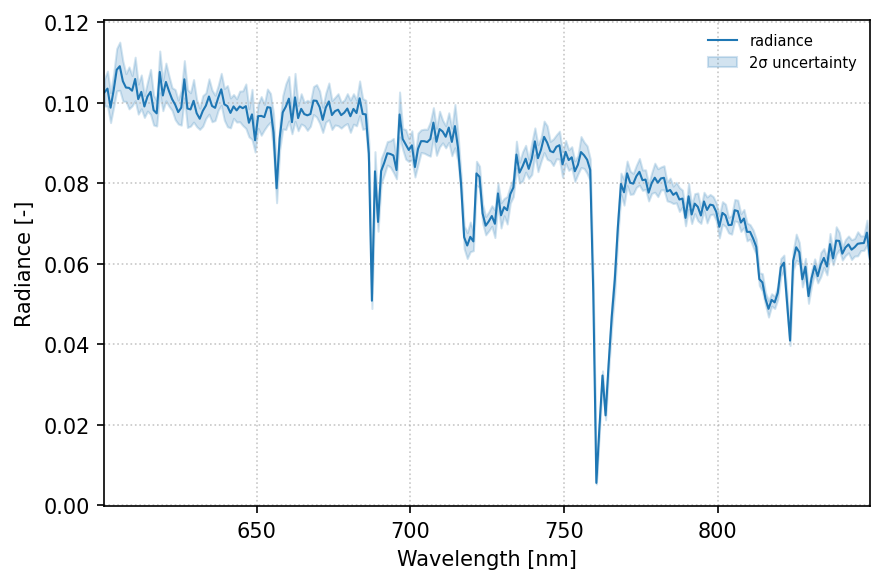

In [5]:
fig, ax = plt.subplots(figsize=(6, 4), dpi=150)

wavelengths = spectral_radiance['w'].values
radiance = spectral_radiance['radiance'].isel(sza=0, saa=0, y_index=0, x_index=0).values
radiance_var = spectral_radiance['radiance_var'].isel(sza=0, saa=0, y_index=0, x_index=0).values
std = np.sqrt(radiance_var)
upper = (radiance + 2 * std).squeeze()
lower = (radiance - 2 * std).squeeze()

ax.plot(wavelengths, radiance, label='radiance', color='tab:blue', lw=1)
ax.fill_between(
        wavelengths, upper, lower, alpha=0.2, color="tab:blue", label='2σ uncertainty'
    )
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Radiance [-]')
ax.set_xlim(wavelengths[0], wavelengths[-1])
ax.grid(True, linestyle=':', alpha=0.7)
ax.legend(fontsize=7, loc='upper right', frameon=False)
fig.tight_layout()
plt.savefig("hyperspectral_radiance_toa.pdf", bbox_inches='tight') 
plt.show()


The result shows the normalized radiance spectrum. We used 1000 samples only, this means we can expect significant noise (as visualized by two standard deviations). We clearly see the O2A (~760 nm) and O2B (~686nm) bands and the water vapor absorption bands around 725nm and 825nm.   